In [18]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [2]:
# Define the base path to the input dataset and then use it to derive
# the path to the input images and annotation CSV files
BASE_PATH = "Dataset"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "annotations"])

Initializing the list of:
1. data (images)
2. class labels
3. target (bounding box coordinates)
4. image paths

In [3]:
data = []
labels = []
bboxes = []
imagePaths = []

In [4]:
csvPaths = []
for (rootDir, dirNames, filenames) in os.walk(ANNOTS_PATH):
    # Loop over the filenames in the current directory
    for filename in filenames:
        # Determine the file extension of the current file
        ext = filename[filename.rfind("."):].lower()
        # The rfind() method returns the highest index of the substring (if found). 
        # If not found, it returns -1.
        print(filename.rfind("."))
        print(filename[filename.rfind("."):])

        # Check to see if the file is an image and should be processed
        if ext.endswith(".csv"):
            # Construct the path to the image and yield it
            csvPath = os.path.join(rootDir, filename)
            csvPaths.append(csvPath)

csvPaths

4
.csv
10
.csv
8
.csv


['Dataset/annotations/face.csv',
 'Dataset/annotations/motorcycle.csv',
 'Dataset/annotations/airplane.csv']

In [5]:
# loop over all CSV files in the annotations directory
for csvPath in csvPaths:
    # load the contents of the current CSV annotations file
    rows = open(csvPath).read().strip().split("\n")

    # loop over the rows
    for row in rows:
        # break the row into the filename, bounding box coordinates,
        # and class label
        row = row.split(",")
        (filename, startX, startY, endX, endY, label) = row

        # derive the path to the input image, load the image (in
        # OpenCV format), and grab its dimensions
        imagePath = os.path.sep.join([IMAGES_PATH, label, filename])
        image = cv2.imread(imagePath)
        (h, w) = image.shape[:2]

        # scale the bounding box coordinates relative to the spatial
        # dimensions of the input image
        startX = float(startX) / w
        startY = float(startY) / h
        endX = float(endX) / w
        endY = float(endY) / h

        # load the image and preprocess it
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
        # print(image) # look at the difference with np.arraay(image)

        # update our list of data, class labels, bounding boxes, and
        # image paths
        data.append(image)
        labels.append(label)
        # print(labels)
        bboxes.append((startX, startY, endX, endY))
        imagePaths.append(imagePath)

In [6]:
# Convert the data, class labels, bounding boxes, and image paths to: 
# NumPy arrays
# Scaling the input pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)


In [7]:
# Perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [8]:
# Partition the data into:
# training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, labels, bboxes, imagePaths, test_size=0.20, random_state=42)
# Unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [9]:
# Load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

58889256/58889256 [==============================] - 3s 0us/step


In [10]:
# Freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False

In [11]:
# Flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# Construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

# Construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax", name="class_label")(softmaxHead)

# Put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(inputs=vgg.input, outputs=(bboxHead, softmaxHead))


In [12]:
# Define a dictionary to set the loss methods: 
# Categorical cross-entropy for --> class label head 
# Mean Squared Error for --> bounding box head
losses = {
    "class_label": "categorical_crossentropy",
    "bounding_box": "mean_squared_error",
}

# Define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}

In [13]:
# Initialize the optimizer
# Compile the model 
# Model summary
opt = Adam(lr=1e-4)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
# Notice that, we have two targets: two heads:
# 1. Bounding Box Regressin
# 2. Label Classification

# Construct a dictionary for our target training outputs
trainTargets = {
    "class_label": trainLabels,
    "bounding_box": trainBBoxes
}

# Construct a second dictionary, this one for our target testing outputs
testTargets = {
    "class_label": testLabels,
    "bounding_box": testBBoxes
}

# train the network for bounding box regression and class label
# prediction
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=32,
    epochs=20,
    verbose=1)

Epoch 1/20
51/51 [==============================] - 26s 281ms/step - loss: 0.1967 - bounding_box_loss: 0.0093 - class_label_loss: 0.1874 - bounding_box_accuracy: 0.6777 - class_label_accuracy: 0.9317 - val_loss: 0.0034 - val_bounding_box_loss: 0.0015 - val_class_label_loss: 0.0019 - val_bounding_box_accuracy: 0.9115 - val_class_label_accuracy: 1.0000
Epoch 2/20
51/51 [==============================] - 10s 189ms/step - loss: 0.0159 - bounding_box_loss: 0.0011 - class_label_loss: 0.0147 - bounding_box_accuracy: 0.8579 - class_label_accuracy: 0.9957 - val_loss: 0.0019 - val_bounding_box_loss: 0.0011 - val_class_label_loss: 7.9077e-04 - val_bounding_box_accuracy: 0.8354 - val_class_label_accuracy: 1.0000
Epoch 3/20
51/51 [==============================] - 10s 191ms/step - loss: 0.0080 - bounding_box_loss: 8.1845e-04 - class_label_loss: 0.0072 - bounding_box_accuracy: 0.8579 - class_label_accuracy: 0.9982 - val_loss: 0.0015 - val_bounding_box_loss: 0.0010 - val_class_label_loss: 4.5040e-04 

In [15]:
model.save('3.h5', save_format="h5")
with open('lb3.pickle', "wb") as f:
    f.write(pickle.dumps(lb))

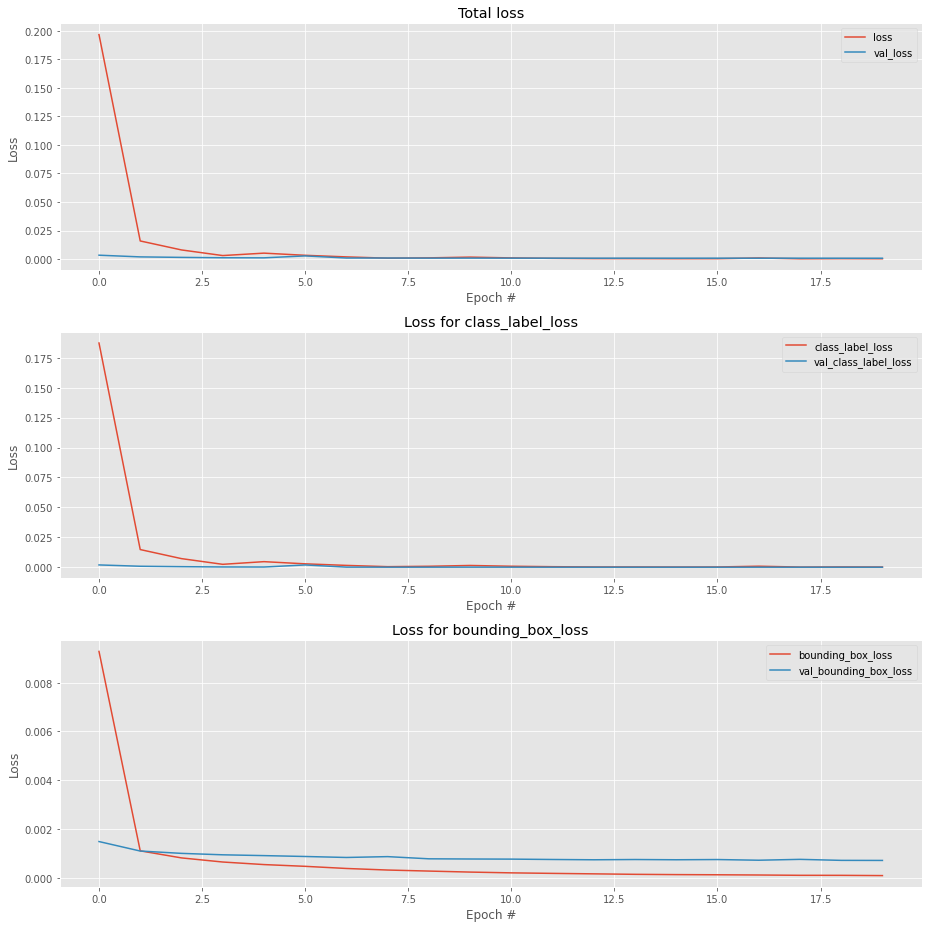

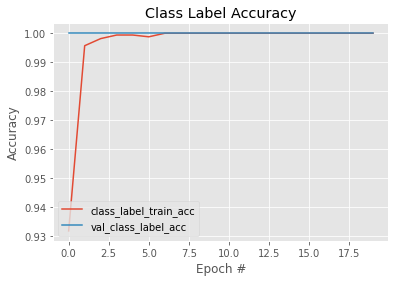

In [16]:
# Plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, H.params['epochs'])
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

# Loop over the loss names
for (i, l) in enumerate(lossNames):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, H.history[l], label=l)
    ax[i].plot(N, H.history["val_" + l], label="val_" + l)
    ax[i].legend()

# save the losses figure and create a new figure for the accuracies
plt.tight_layout()

# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"], label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"], label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

# Implementing the object detection prediction script with Keras and TensorFlow

In [30]:
# Load object detector and label binarizer
print("[INFO] loading object detector...")
model = load_model('3.h5')
lb = pickle.loads(open('lb3.pickle', "rb").read())

[INFO] loading object detector...


In [31]:
def inference(imagePath):
    # load the input image (in Keras format) from disk and preprocess
    # it, scaling the pixel intensities to the range [0, 1]
    image = load_img(imagePath, target_size=(224, 224))
    # Load the input image (in Keras format) from disk and preprocess
	  # it, scaling the pixel intensities to the range [0, 1]
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    return model.predict(image)

In [36]:
def draw_bbox(img, boxPreds, labelPreds):
    image = np.copy(img)
    (h, w) = image.shape[:2]
    
    # Predict the bounding box of the object along with the class label
    (startX, startY, endX, endY) = boxPreds[0]

    # Determine the class label with the largest predicted probability
    i = np.argmax(labelPreds, axis=1)
    label = lb.classes_[i][0]

    # Scale the predicted bounding box coordinates based on the image dimensions
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)

    # Draw the predicted bounding box and class label on the image
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
        0.65, (0, 255, 0), 2)
    cv2.rectangle(image, (startX, startY), (endX, endY),
        (0, 255, 0), 2)
    
    return image

1/1 [==============================] - 0s 17ms/step


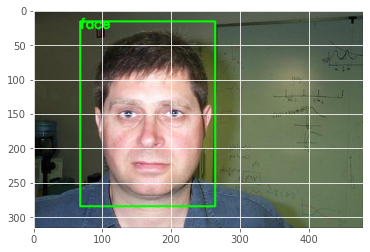

In [37]:
imagePath='./Dataset/images/face/image_0011.jpg'
image = plt.imread(imagePath)
(boxPreds, labelPreds) = inference(imagePath)
image_with_bbox = draw_bbox(image, boxPreds, labelPreds)
plt.imshow(image_with_bbox)

https://www.pyimagesearch.com/2020/10/12/multi-class-object-detection-and-bounding-box-regression-with-keras-tensorflow-and-deep-learning/


